In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
from gprofiler import GProfiler
import pandas as pd
from numpy import nan

In [3]:
enrichment=great.tl.enrichment(
    test="../data/input/binom/genomic_region_test.bed",
    regdomFn="../data/input/binom/regdom.out",
    Chr_sizeFn="../data/input/regdom/chr_size.txt",
    annotation="../data/input/binom/ontologies.csv",
    binom=False,
    hypergeom=True,
    correction=("fdr",0.005)
    )

c:\Users\Tom\anaconda3\lib\site-packages\statsmodels\stats\multitest.py:339: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
c:\Users\Tom\anaconda3\lib\site-packages\statsmodels\stats\multitest.py:347: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [4]:
enrichment.head()

,go_term,hypergeom_p_value,hypergeom_fdr_correction
GO:0005654,nucleoplasm,1.12958e-132,6.70973e-130
GO:0005886,plasma membrane,1.26016e-30,3.74268e-28
GO:0005576,extracellular region,1.38134e-16,2.73504e-14
GO:0032982,myosin filament,2.95945e-05,3.51583e-03
GO:0005859,muscle myosin complex,2.95945e-05,3.51583e-03


# Preprocessing of the data 

In [5]:
L=[]
f = open("../data/input/binom/genomic_region_test.bed")
cdc=f.readline()
while cdc != "": 
    cdc = cdc.split("\t")
    cdc = ":".join(cdc)
    cdc = cdc.strip()
    L.append(cdc[3:])
    cdc = f.readline()

In [6]:
back=pd.read_csv("../data/input/binom/regdom.out",sep="\t",comment="#",
                    names=["Chr", "Chr_Start", "Chr_End","Name","tss","Strand"],dtype={"Chr":"object", "Chr_Start":"int64", "Chr_End":"int64","Name":"object","tss":"int64","Strand":"object"})
back = list(back["Name"])

# Profile with GProfiler

In [7]:
gp_no_correct = GProfiler(return_dataframe=True)
gp_no_correct = gp_no_correct.profile(organism='hsapiens',
            query=L,
            all_results=True,
            background=back,user_threshold=0.005)

gp_no_correct = gp_no_correct.loc[(gp_no_correct["source"]=="GO:MF")|(gp_no_correct["source"]=="GO:CC")|(gp_no_correct["source"]=="GO:BP")]
gp_no_correct

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
14,GO:CC,GO:0005801,cis-Golgi network,3.21896e-01,False,"""The network of interconnected tubular and cis...",66,22,2,23017,9.09091e-02,3.03030e-02,query_1,"[GO:0005794, GO:0043231]"
16,GO:CC,GO:0034687,integrin alphaL-beta2 complex,3.41207e-01,False,"""An integrin complex that comprises one alphaL...",2,22,1,23017,4.54545e-02,5.00000e-01,query_1,[GO:0008305]
19,GO:CC,GO:1990429,peroxisomal importomer complex,5.11577e-01,False,"""A protein complex responsible for transportin...",3,22,1,23017,4.54545e-02,3.33333e-01,query_1,[GO:1990351]
20,GO:CC,GO:0035868,alphav-beta3 integrin-HMGB1 complex,5.11577e-01,False,"""A protein complex that consists of an alphav-...",3,22,1,23017,4.54545e-02,3.33333e-01,query_1,[GO:0098797]
21,GO:MF,GO:0019002,GMP binding,5.24934e-01,False,"""Binding to GMP, guanosine monophosphate."" [GO...",2,22,1,23017,4.54545e-02,5.00000e-01,query_1,"[GO:0032561, GO:0043168]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,GO:BP,GO:0032268,regulation of cellular protein metabolic process,1.00000e+00,False,"""Any process that modulates the frequency, rat...",2297,22,2,23017,9.09091e-02,8.70701e-04,query_1,"[GO:0031323, GO:0044267, GO:0051246]"
5843,GO:BP,GO:0032103,positive regulation of response to external st...,1.00000e+00,False,"""Any process that activates, maintains or incr...",440,22,1,23017,4.54545e-02,2.27273e-03,query_1,"[GO:0009605, GO:0032101, GO:0048584]"
5844,GO:BP,GO:0032101,regulation of response to external stimulus,1.00000e+00,False,"""Any process that modulates the frequency, rat...",926,22,1,23017,4.54545e-02,1.07991e-03,query_1,"[GO:0009605, GO:0048583]"
5845,GO:BP,GO:0032091,negative regulation of protein binding,1.00000e+00,False,"""Any process that stops, prevents, or reduces ...",91,22,1,23017,4.54545e-02,1.09890e-02,query_1,"[GO:0043393, GO:0051100]"


# Add the GProfiler pvalue on the BinomP_and_HypergeomP df

In [8]:
val=[]
for i in enrichment.index: 
    try : 
        val.append(float(gp_no_correct.loc[gp_no_correct["native"]==i]["p_value"]))
    except:
        val.append(nan)
enrichment["gprofile_p_val"] = val
enrichment

,go_term,hypergeom_p_value,hypergeom_fdr_correction,gprofile_p_val
GO:0005654,nucleoplasm,1.12958e-132,6.70973e-130,1.00000e+00
GO:0005886,plasma membrane,1.26016e-30,3.74268e-28,1.00000e+00
GO:0005576,extracellular region,1.38134e-16,2.73504e-14,1.00000e+00
GO:0032982,myosin filament,2.95945e-05,3.51583e-03,1.00000e+00
GO:0005859,muscle myosin complex,2.95945e-05,3.51583e-03,1.00000e+00
...,...,...,...,...
GO:0006888,ER to Golgi vesicle-mediated transport,3.71300e-01,3.71930e-01,1.00000e+00
GO:0031410,cytoplasmic vesicle,3.71304e-01,3.71930e-01,1.00000e+00
GO:0007049,cell cycle,3.71304e-01,3.71930e-01,NaN
GO:0005515,protein binding,NaN,NaN,1.00000e+00


# Plot the p-value without correction

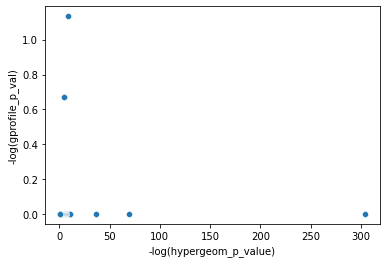

In [9]:
great.pl.scatterplot(enrichment,"hypergeom_p_value","gprofile_p_val",minus_log10=True)

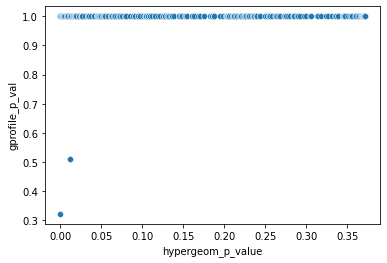

In [10]:
great.pl.scatterplot(enrichment,"hypergeom_p_value","gprofile_p_val",minus_log10=False)

We can see that the values are totally different between the one returned by greatpy and GProfile. I have not been able to check my results on the great webserver for the moment because it is no longer accessible. 

However, it seems very strange that gprofile_p_val only returns 1. Could be related to the selection of GO ID between enrichment and gp

# Comparison with a fdr correction

In [11]:
gp_correct = GProfiler(return_dataframe=True)
gp_correct = gp_correct.profile(organism='hsapiens',
            query=L,
            all_results=True,
            background=back,
            user_threshold=0.005,
            significance_threshold_method="fdr")

gp_correct = gp_correct.loc[(gp_correct["source"]=="GO:MF")|(gp_correct["source"]=="GO:CC")|(gp_correct["source"]=="GO:BP")]
gp_correct

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
125,GO:MF,GO:0030369,ICAM-3 receptor activity,1.12291e-01,False,"""Combining with ICAM-3, intercellular adhesion...",3,22,1,23017,4.54545e-02,3.33333e-01,query_1,[GO:0004888]
126,GO:MF,GO:0019002,GMP binding,1.12291e-01,False,"""Binding to GMP, guanosine monophosphate."" [GO...",2,22,1,23017,4.54545e-02,5.00000e-01,query_1,"[GO:0032561, GO:0043168]"
127,GO:MF,GO:0044323,retinoic acid-responsive element binding,1.12291e-01,False,"""Binding to a retinoic acid-responsive element...",6,22,1,23017,4.54545e-02,1.66667e-01,query_1,[GO:0000978]
128,GO:MF,GO:0047485,protein N-terminus binding,1.12291e-01,False,"""Binding to a protein N-terminus, the end of a...",107,22,2,23017,9.09091e-02,1.86916e-02,query_1,[GO:0005515]
129,GO:MF,GO:0016531,copper chaperone activity,1.12291e-01,False,"""Directly binding to and delivering copper ion...",6,22,1,23017,4.54545e-02,1.66667e-01,query_1,[GO:0016530]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697,GO:BP,GO:0048584,positive regulation of response to stimulus,8.71223e-01,False,"""Any process that activates, maintains or incr...",2020,22,1,23017,4.54545e-02,4.95050e-04,query_1,"[GO:0048518, GO:0048583, GO:0050896]"
6698,GO:BP,GO:0008219,cell death,8.71223e-01,False,"""Any biological process that results in perman...",2024,22,1,23017,4.54545e-02,4.94071e-04,query_1,[GO:0009987]
6974,GO:BP,GO:0003008,system process,8.87446e-01,False,"""A multicellular organismal process carried ou...",2157,22,1,23017,4.54545e-02,4.63607e-04,query_1,[GO:0032501]
7217,GO:BP,GO:0071310,cellular response to organic substance,9.05417e-01,False,"""Any process that results in a change in state...",2328,22,1,23017,4.54545e-02,4.29553e-04,query_1,"[GO:0010033, GO:0070887]"


In [12]:
val=[]
for i in enrichment.index: 
    try : 
        val.append(float(gp_correct.loc[gp_correct["native"]==i]["p_value"]))
    except:
        val.append(nan)
enrichment["gprofile_p_val"] = val
enrichment

,go_term,hypergeom_p_value,hypergeom_fdr_correction,gprofile_p_val
GO:0005654,nucleoplasm,1.12958e-132,6.70973e-130,4.61076e-01
GO:0005886,plasma membrane,1.26016e-30,3.74268e-28,6.62298e-01
GO:0005576,extracellular region,1.38134e-16,2.73504e-14,2.91448e-01
GO:0032982,myosin filament,2.95945e-05,3.51583e-03,2.33605e-01
GO:0005859,muscle myosin complex,2.95945e-05,3.51583e-03,2.29361e-01
...,...,...,...,...
GO:0006888,ER to Golgi vesicle-mediated transport,3.71300e-01,3.71930e-01,1.65146e-01
GO:0031410,cytoplasmic vesicle,3.71304e-01,3.71930e-01,2.91448e-01
GO:0007049,cell cycle,3.71304e-01,3.71930e-01,NaN
GO:0005515,protein binding,NaN,NaN,3.60204e-01


# Plot of the p-value with correction

In [13]:
enrichment

,go_term,hypergeom_p_value,hypergeom_fdr_correction,gprofile_p_val
GO:0005654,nucleoplasm,1.12958e-132,6.70973e-130,4.61076e-01
GO:0005886,plasma membrane,1.26016e-30,3.74268e-28,6.62298e-01
GO:0005576,extracellular region,1.38134e-16,2.73504e-14,2.91448e-01
GO:0032982,myosin filament,2.95945e-05,3.51583e-03,2.33605e-01
GO:0005859,muscle myosin complex,2.95945e-05,3.51583e-03,2.29361e-01
...,...,...,...,...
GO:0006888,ER to Golgi vesicle-mediated transport,3.71300e-01,3.71930e-01,1.65146e-01
GO:0031410,cytoplasmic vesicle,3.71304e-01,3.71930e-01,2.91448e-01
GO:0007049,cell cycle,3.71304e-01,3.71930e-01,NaN
GO:0005515,protein binding,NaN,NaN,3.60204e-01


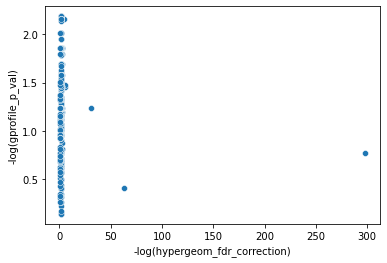

In [14]:
# great.pl.scatterplot(enrichment,"hypergeom_fdr_correction","gprofile_p_val",minus_log10=True)
great.pl.scatterplot(enrichment,"hypergeom_fdr_correction","gprofile_p_val",minus_log10=True)

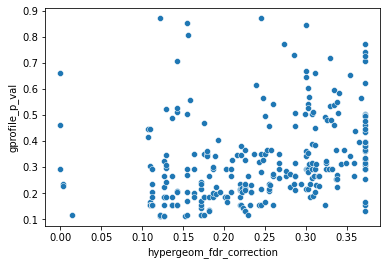

In [15]:
great.pl.scatterplot(enrichment,"hypergeom_fdr_correction","gprofile_p_val",minus_log10=False)

With a correction we observe that the distribution of p-value is slightly better. Although the values are probably wrong the fdr correction seems very important. 